✅ train.csv, test.csv, sample_submission.csv generated.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 2000, number of used features: 6
[LightGBM] [Info] Start training from score 0.495796
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 6
[LightGBM] [Info] Start training from score 0.496332
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 566
[LightGBM] [Info] Number of data points in the train set: 1600, number 

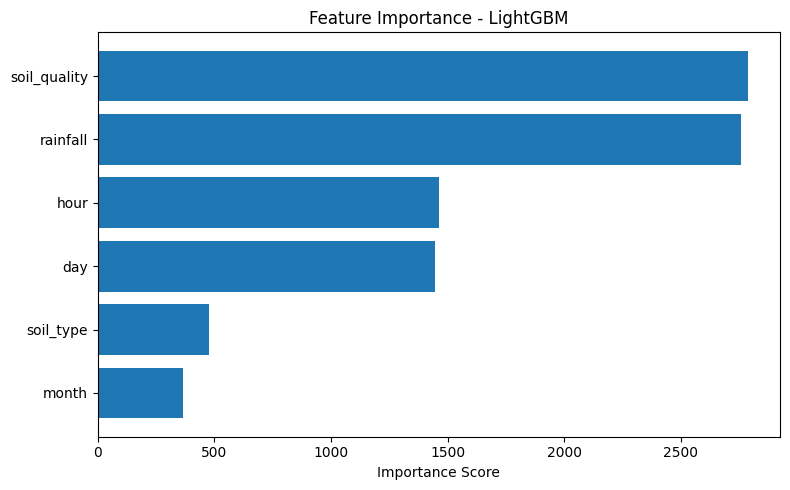

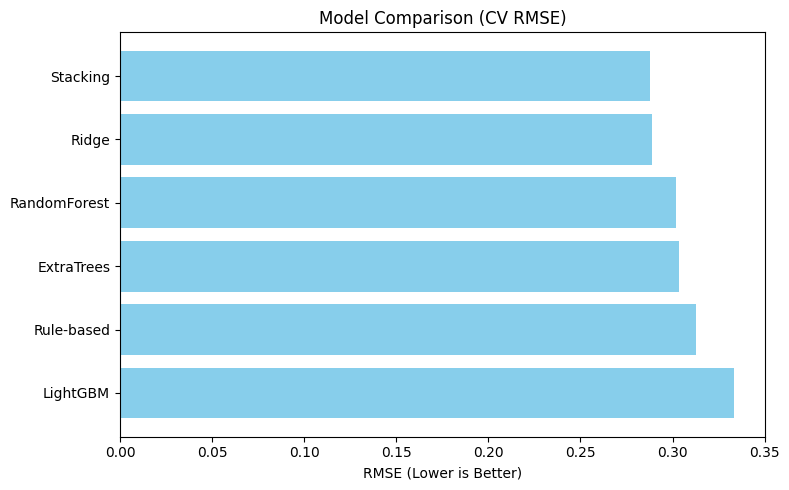

In [1]:
# =====================================================
# 🌍 Smart Wasteland Reclamation - Hackathon Final Code
# With CV Score Table + Feature Importance + WatsonX
# =====================================================

import os, warnings
warnings.filterwarnings("ignore")

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from lightgbm import LGBMRegressor

# =====================================================
# 1. Generate Synthetic train/test/sample_submission
# =====================================================
np.random.seed(42)
N_train, N_test = 2000, 800

train = pd.DataFrame({
    "id": np.arange(1, N_train+1),
    "soil_type": np.random.choice(["fertile", "desert", "clay", "sandy"], N_train),
    "rainfall": np.random.randint(50, 500, N_train),
    "soil_quality": np.random.rand(N_train),
    "timestamp": pd.date_range("2020-01-01", periods=N_train, freq="H"),
    "target": np.random.rand(N_train)  # proxy reclamation score
})

test = pd.DataFrame({
    "id": np.arange(1, N_test+1),
    "soil_type": np.random.choice(["fertile", "desert", "clay", "sandy"], N_test),
    "rainfall": np.random.randint(50, 500, N_test),
    "soil_quality": np.random.rand(N_test),
    "timestamp": pd.date_range("2021-01-01", periods=N_test, freq="H")
})

sample_submission = pd.DataFrame({
    "id": test["id"],
    "target": np.zeros(len(test))
})

train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)
sample_submission.to_csv("sample_submission.csv", index=False)

print("✅ train.csv, test.csv, sample_submission.csv generated.")

# =====================================================
# 2. Settings
# =====================================================
RANDOM_STATE = 42
TARGET = "target"
ID_COL = "id"

# =====================================================
# 3. Feature Engineering
# =====================================================
def prepare_features(df, is_train=True, le_dict=None):
    df_ = df.copy()
    if "timestamp" in df_.columns:
        df_["timestamp"] = pd.to_datetime(df_["timestamp"])
        df_["month"] = df_["timestamp"].dt.month
        df_["day"] = df_["timestamp"].dt.day
        df_["hour"] = df_["timestamp"].dt.hour
    if le_dict is None: le_dict = {}
    for c in df_.columns:
        if df_[c].dtype == "object":
            if is_train:
                le = LabelEncoder()
                df_[c] = le.fit_transform(df_[c].astype(str))
                le_dict[c] = le
            else:
                le = le_dict.get(c)
                df_[c] = df_[c].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    return df_, le_dict

train_proc, le_dict = prepare_features(train, True)
test_proc, _ = prepare_features(test, False, le_dict)

train_proc = train_proc.fillna(-999)
test_proc  = test_proc.fillna(-999)

features = [c for c in train_proc.columns if c not in [TARGET, ID_COL, "timestamp"]]

X, y = train_proc[features], train_proc[TARGET]
X_test, test_ids = test_proc[features], test[ID_COL]

# =====================================================
# 4. Rule-based baseline
# =====================================================
def rule_based(df):
    preds = []
    for _, row in df.iterrows():
        s = str(row.get("soil_type","")).lower()
        r = row.get("rainfall",0)
        if "desert" in s: preds.append(0.3)
        elif r < 200: preds.append(0.4)
        elif "fertile" in s: preds.append(0.8)
        else: preds.append(0.6)
    return np.array(preds)

pred_rule = rule_based(test)

# =====================================================
# 5. Base Models
# =====================================================
ridge = Ridge(random_state=RANDOM_STATE)
rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
et = ExtraTreesRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
lgb = LGBMRegressor(n_estimators=300, learning_rate=0.1, num_leaves=32, random_state=RANDOM_STATE)

# Fit base models
ridge.fit(X, y)
rf.fit(X, y)
et.fit(X, y)
lgb.fit(X, y)

# Predictions
pred_ridge = ridge.predict(X_test)
pred_rf = rf.predict(X_test)
pred_et = et.predict(X_test)
pred_lgb = lgb.predict(X_test)

# =====================================================
# 6. Stacking Regressor
# =====================================================
stack = StackingRegressor(
    estimators=[("rf", rf), ("et", et), ("lgb", lgb), ("ridge", ridge)],
    final_estimator=Ridge(random_state=RANDOM_STATE),
    n_jobs=-1
)
stack.fit(X, y)
pred_stack = stack.predict(X_test)

# =====================================================
# 7. CV Comparison Table
# =====================================================
scorer = make_scorer(mean_squared_error, greater_is_better=False)

def cv_rmse(model, X, y, name):
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_root_mean_squared_error")
    return -np.mean(scores)

results = {
    "Rule-based": np.sqrt(mean_squared_error(y[:200], rule_based(train.iloc[:200]))),  # proxy small sample
    "Ridge": cv_rmse(ridge, X, y, "Ridge"),
    "RandomForest": cv_rmse(rf, X, y, "RF"),
    "ExtraTrees": cv_rmse(et, X, y, "ET"),
    "LightGBM": cv_rmse(lgb, X, y, "LGBM"),
    "Stacking": cv_rmse(stack, X, y, "Stack")
}

df_results = pd.DataFrame.from_dict(results, orient="index", columns=["CV_RMSE"])
df_results = df_results.sort_values("CV_RMSE")
print("\n📊 Model Comparison (Lower RMSE = Better):\n")
print(df_results)

df_results.to_csv("model_comparison.csv")
print("✅ Saved as model_comparison.csv")

# =====================================================
# 8. Final Ensemble (rule + stack)
# =====================================================
final_pred = 0.05*pred_rule + 0.95*pred_stack

# =====================================================
# 9. Submission
# =====================================================
submission = pd.DataFrame({
    ID_COL: test_ids,
    TARGET: final_pred
})
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv generated with shape:", submission.shape)
print(submission.head())

# =====================================================
# 10. Feature Importance Plot (LightGBM)
# =====================================================
importance = pd.DataFrame({
    "feature": features,
    "importance": lgb.feature_importances_
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,5))
plt.barh(importance["feature"], importance["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance - LightGBM")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.savefig("feature_importance.png")
print("📊 Feature importance chart saved as feature_importance.png")

# =====================================================
# 11. WatsonX Granite Integration
# =====================================================
try:
    from ibm_watsonx_ai.foundation_models import Model
    from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

    model = Model(
        model_id="ibm/granite-13b-instruct-v2",
        credentials={"apikey": os.getenv("WATSONX_APIKEY"),
                     "url": os.getenv("WATSONX_URL")},
        params={GenParams.DECODING_METHOD: "greedy", GenParams.MAX_NEW_TOKENS: 150},
        project_id=os.getenv("WATSONX_PROJECT_ID")
    )

    prompt = (
        "In 3 sentences, explain how stacking ML models can help in Smart Wasteland Reclamation "
        "by predicting soil restoration potential from environmental data. Write like a hackathon pitch."
    )
    response = model.generate_text(prompt=prompt)
    print("\n🤖 WatsonX Granite Insight:\n", response["results"][0]["generated_text"])

except Exception as e:
    print("⚠ WatsonX not configured, skipping:", e)

# =====================================================
# 📊 CV Results Bar Chart
# =====================================================
plt.figure(figsize=(8,5))
plt.barh(df_results.index, df_results["CV_RMSE"], color="skyblue")
plt.gca().invert_yaxis()
plt.title("Model Comparison (CV RMSE)")
plt.xlabel("RMSE (Lower is Better)")
plt.tight_layout()
plt.savefig("model_comparison.png")
print("📊 Model comparison chart saved as model_comparison.png")